In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from svgp.jax.quadrature import expectation_1d

In [2]:
x_i = np.array([-0.86, -0.3, -0.05, 0.73])
n_i = np.repeat(5., 4)
y_i = np.array([0, 1, 3, 5])

In [3]:
X = np.stack([np.ones_like(x_i), x_i], axis=1)

In [9]:
# Initialise parameters
n_params = X.shape[1]
n_sites = X.shape[0] + 1


In [53]:
X.shape

(4, 2)

In [10]:
precs.shape

(5, 2, 2)

In [44]:
from functools import partial

In [43]:
from jax.nn import sigmoid

def binomial_lik(x, y, m, moment=0.):
    
    succ_prob = sigmoid(x)
    bin_part = succ_prob**y * (1 - succ_prob)**(m - y)
    
    return x**moment * bin_part

In [68]:
from tqdm.notebook import tqdm

In [116]:
# This seems sensitive to the choice of the constant in the prec.
# 1e-3 worked. But 1e-2 didn't for example.

vecs = np.zeros((n_sites, n_params))
precs = 1e-4 * np.tile(np.eye(n_params), (n_sites, 1, 1))

pred_means = list()
pred_covs = list()

for _ in tqdm(range(20)):
    
    full_vec = np.sum(vecs, axis=0)
    full_prec = np.sum(precs, axis=0)
    
    pred_mean = np.linalg.solve(full_prec, full_vec)
    pred_cov = np.linalg.inv(full_prec)
    
    pred_means.append(pred_mean)
    pred_covs.append(pred_cov)

    for i in range(1, n_sites):

        full_vec = np.sum(vecs, axis=0)
        full_prec = np.sum(precs, axis=0)

        cur_vec = full_vec - vecs[i]
        cur_prec = full_prec - precs[i]
        cur_x = X[i - 1]

        cur_V = cur_x @ np.linalg.solve(cur_prec, cur_x)

        # Double check this one!
        cur_M = cur_x @ np.linalg.solve(cur_prec, cur_vec)

        # Compute moments
        cur_lik = partial(binomial_lik, y=y_i[i - 1], m=5)

        zeroth_moment = partial(cur_lik, moment=0.)
        first_moment = partial(cur_lik, moment=1.)
        second_moment = partial(cur_lik, moment=2.)

        zeroth_moment = expectation_1d(zeroth_moment, cur_M, cur_V)
        first_moment = expectation_1d(first_moment, cur_M, cur_V)
        second_moment = expectation_1d(second_moment, cur_M, cur_V)

        M = first_moment / zeroth_moment
        V = second_moment / zeroth_moment - M**2

        M_i_V_i = M / V - cur_M / cur_V
        inv_V_i = 1 / V - 1 / cur_V

        trans_vec = cur_x * M_i_V_i
        trans_prec = inv_V_i * np.outer(cur_x, cur_x)

        vecs[i] = trans_vec
        precs[i] = trans_prec

In [117]:
mean_log = np.array(pred_means)

In [118]:
mean_log

array([[ 0.        ,  0.        ],
       [ 4.05241144,  6.68086275],
       [ 0.73301093,  6.38251291],
       [ 1.1920429 , 10.38386587],
       [ 1.27846932, 11.28819757],
       [ 1.28129531, 11.46116551],
       [ 1.28271504, 11.49006765],
       [ 1.28309681, 11.49552536],
       [ 1.28313976, 11.49635872],
       [ 1.28314252, 11.49647102],
       [ 1.28314229, 11.49648797],
       [ 1.28314279, 11.49648908],
       [ 1.28314314, 11.49649088],
       [ 1.28314376, 11.496495  ],
       [ 1.28314331, 11.49649467],
       [ 1.28314362, 11.4964961 ],
       [ 1.28314271, 11.496492  ],
       [ 1.28314332, 11.49649468],
       [ 1.28314342, 11.49649201],
       [ 1.28314332, 11.4964911 ]])

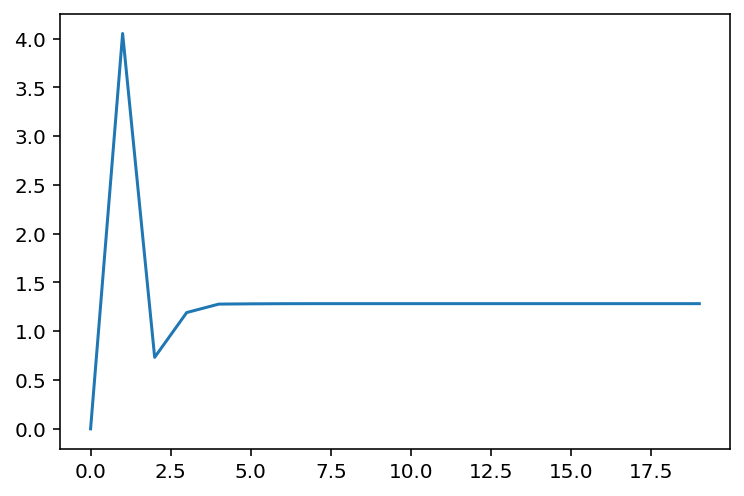

In [119]:
plt.plot(mean_log[:, 0])

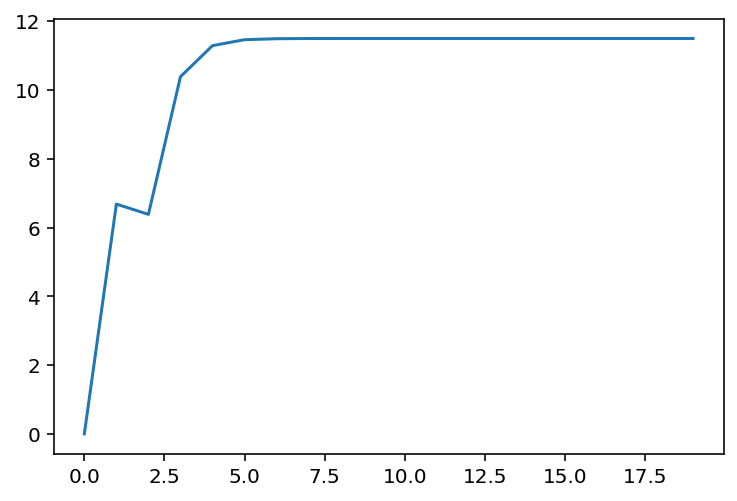

In [120]:
plt.plot(mean_log[:, 1])

In [121]:
pred_covs[-1]

array([[ 1.10028597,  3.11976399],
       [ 3.11976399, 23.14681932]])

In [122]:
from ml_tools.normals import covar_to_corr

covar_to_corr(pred_covs[-1])

array([[1.        , 0.61819188],
       [0.61819188, 1.        ]])